In [1]:
%cd ~/Desktop/ActiveLearningCode/  
# Insert your path to the ActiveLearningCode folder

import scipy as sp
import numpy as np
from sklearn.datasets import make_moons
from util.Graph_manager import Graph_manager
import matplotlib.pyplot as plt
import scipy.linalg as sla
import copy
from util.al_util import *
from scipy.stats import norm
from scipy.optimize import  root


%load_ext autoreload

/Users/Kevin/Desktop/ActiveLearningCode


In [2]:
%autoreload

In [3]:
plt.style.use('ggplot')

## Helper Functions

Includes lots of functions for computing gaussian approximation to probit, with two different pdfs (normal and logistic).

In [4]:
################# Psi = cdf of Normal distribution ########################

def pdf_deriv(t, gamma):
    return -t*norm.pdf(t, scale = gamma)/(gamma**2)


def hess_calc(uj_, yj_, gamma):
    return -(pdf_deriv(uj_*yj_, gamma)*norm.cdf(uj_*yj_,scale=gamma)
                     - norm.pdf(uj_*yj_,scale=gamma)**2)/ (norm.cdf(uj_*yj_,scale=gamma)**2)

def Hess(u, y, labeled, Lt, gamma, debug=False):
    """
    Assuming matrices are sparse, since L_tau should be relatively sparse, 
        and we are perturbing with diagonal matrix.
    """
    H_d = np.zeros(u.shape[0])
    for j, yj in zip(labeled, y):
        H_d[j] = hess_calc(u[j], yj, gamma)
    if debug:
        print(H_d[np.nonzero(H_d)])
    if np.any(H_d == np.inf):
        print('smally')
    return Lt + sp.sparse.diags(H_d, format='csr')

def J(u, y, labeled, Lt, gamma, debug=False):
    vec = np.zeros(u.shape[0])
    for j, yj in zip(labeled,y):
        vec[j] = -yj*norm.pdf(u[j]*yj, gamma)/norm.cdf(u[j]*yj, gamma)
    if debug:
        print(vec[np.nonzero(vec)])
    return Lt @ u + vec

def probit_map_dr(Z_, yvals, gamma, Ct):
    """
    Probit MAP estimator, using dimensionality reduction via Representer Theorem.
    *** This uses cdf of normal distribution ***
    
    Deprecated?
    """
    Ctp = Ct[np.ix_(Z_,Z_)]
    J = len(yvals)
    #print(Ctp)
    def f(x):
        vec = [yj*norm.pdf(x[j]*yj, scale=gamma)/norm.cdf(x[j]*yj, scale=gamma) for j,yj in enumerate(yvals)]
        if np.any(vec == np.inf):
            print('smally in f')
        #print(sla.norm(x - Ctp @ vec))
        #print(vec)
        return x - Ctp @ vec
    
    def fprime(x):
        H = -Ctp * np.array([(pdf_deriv(x[j]*yj,gamma)*norm.cdf(x[j]*yj,scale=gamma)
                         - norm.pdf(x[j]*yj,scale=gamma)**2)/ (norm.cdf(x[j]*yj,scale=gamma)**2)
                            for j, yj in enumerate(yvals)])
        if np.any(H == np.inf):
            print('smally')
        H[np.diag_indices(J)] += 1.0
        return H
    
    x0 = np.random.rand(J)
    x0[np.array(yvals) < 0] *= -1
    res = root(f, x0, jac=fprime)
    print(np.allclose(0., f(res.x)))
    
    
    tmp = sla.inv(Ctp) @ res.x
    
    return Ct[:, Z_] @ tmp


In [5]:
###################### Psi = cdf of logistic #######################
def log_pdf(t, g):
    return np.exp(-t/g)/(g*(1. + np.exp(-t/g)))

def log_cdf(t, g):
    return 1.0/(1.0 + np.exp(-t/g))

def log_pdf_deriv(t, g):
    return -np.exp(-t/g)/((g*(1. + np.exp(-t/g)))**2.)


def hess_calc2(uj_, yj_, gamma):
    return -(log_pdf_deriv(uj_*yj_, gamma)*log_cdf(uj_*yj_, gamma)
                     - log_pdf(uj_*yj_, gamma)**2)/ (log_cdf(uj_*yj_, gamma)**2)

def Hess2(u, y, labeled, Lt, gamma, debug=False):
    """
    Assuming matrices are sparse, since L_tau should be relatively sparse, 
        and we are perturbing with diagonal matrix.
    """
    H_d = np.zeros(u.shape[0])
    for j, yj in zip(labeled, y):
        H_d[j] = hess_calc2(u[j], yj, gamma)
    if debug:
        print(H_d[np.nonzero(H_d)])
    if np.any(H_d == np.inf):
        print('smally')
    return Lt + sp.sparse.diags(H_d, format='csr')

def J2(u, y, labeled, Lt, gamma, debug=False):
    vec = np.zeros(u.shape[0])
    for j, yj in zip(labeled,y):
        vec[j] = -yj*log_pdf(u[j]*yj, gamma)/log_cdf(u[j]*yj, gamma)
    if debug:
        print(vec[np.nonzero(vec)])
    return Lt @ u + vec


def probit_map_dr2(Z_, yvals, gamma, Ct):
    """
    Probit MAP estimator, using dimensionality reduction via Representer Theorem.
    *** This uses logistic cdf ***
    """
    
    Ctp = Ct[np.ix_(Z_,Z_)]
    J = len(yvals)
    
    def log_pdf(t):
        return np.exp(-t/gamma)/(gamma*(1. + np.exp(-t/gamma)))
    
    def log_cdf(t):
        return 1.0/(1.0 + np.exp(-t/gamma))
    
    def log_pdf_deriv(t):
        return -np.exp(-t/gamma)/((gamma*(1. + np.exp(-t/gamma)))**2.)
    
    def f(x):
        vec = [yj*log_pdf(x[j]*yj)/log_cdf(x[j]*yj) for j,yj in enumerate(yvals)]
        return x - Ctp @ vec
    
    def fprime(x):
        H = -Ctp * np.array([(log_pdf_deriv(x[j]*yj)*log_cdf(x[j]*yj)
                         - log_pdf(x[j]*yj)**2)/ (log_cdf(x[j]*yj)**2) 
                             for j, yj in enumerate(yvals)])
        if np.any(H == np.inf):
            print('smally')
        H[np.diag_indices(J)] += 1.0
        return H
    
    x0 = np.random.rand(J)
    x0[np.array(yvals) < 0] *= -1
    res = root(f, x0, jac=fprime)
    
    
    tmp = sla.inv(Ctp) @ res.x
    
    return Ct[:, Z_] @ tmp

In [6]:
def get_acc(u, labels):
    u_ = np.sign(u)
    u_[u_ == 0] = 1
    corr = sum(1.*(u_ == labels))
    
    return corr, corr/u.shape[0]    

# Active Learning with Gaussian Approximation of Probit

### Gaussian Approximation of Probit Posterior

$$
\begin{align}
    p_p(\mathbf{u} | \mathbf{y}) &\propto \exp \left( -\frac{1}{2}\langle \mathbf{u}, L_\tau \mathbf{u}\rangle  + \sum_{j \in Z'} \log \Psi_\gamma(u_j y_j)\right) \\
        & \approx \mathcal{N}\left(\hat{\mathbf{u}}, H_p^{-1}(\hat{\mathbf{u}})  \right)
\end{align}
$$

where $\hat{\mathbf{u}}$ is the MAP estimator of the Probit posterior and $H_p(\hat{\mathbf{u}})$ is the Hessian of the Probit functional 

$$
J_p(\mathbf{u}) = \frac{1}{2}\langle \mathbf{u}, L_\tau \mathbf{u}\rangle  - \sum_{j \in Z'} \log \Psi_\gamma(u_j y_j)
$$
evaluated at the MAP estimate, $\hat{\mathbf{u}}$. 

## Compare with Vopt


We compare how good the choices are between Vopt and FPD, **given the correct labeling at each iteration**. This should help us see just how good these choices could optimally be on a choice by choice basis.

In [80]:
def db_crit(u, unlabeled):
    dist_fromdb = np.absolute(u[unlabeled])
    return unlabeled[np.argmin(dist_fromdb)], dist_fromdb

def jac_calc2(uj_, yj_, gamma):
    return -yj_*log_pdf(uj_*yj_, gamma)/log_cdf(uj_*yj_, gamma)

def fpd_crit__(m, C, unlabeled, gamma):
    mks = np.array([m[k] + C[k,k]*jac_calc2(m[k], 1, gamma)/(hess_calc2(m[k], 1, gamma)*C[k,k] - 1.)
                   for k in unlabeled])
    #print(np.max(mks), np.min(mks))
    mks_ = np.array([m[k] + C[k,k]*jac_calc2(m[k], -1, gamma)/(hess_calc2(m[k], -1, gamma)*C[k,k] - 1.)
                   for k in unlabeled])
    #print(np.max(mks_), np.min(mks_))
    
    fpd = np.array([abs(hess_calc2(mks[i], 1, gamma) - hess_calc2(mks_[i], -1, gamma)) for i in range(len(mks))])
    #best_ind = np.argmin(fpd)
    return unlabeled[np.argmin(fpd)], fpd

def model_change_crit(m, C, unlabeled, gamma):
    mcopts = np.array([np.abs(jac_calc2(m[k], 1, gamma)/(hess_calc2(m[k], 1, gamma)*C[k,k] - 1.))*np.linalg.norm(C[:,k])
                      for k in unlabeled])
    mcopts_ = np.array([np.abs(jac_calc2(m[k], -1, gamma)/(hess_calc2(m[k], -1, gamma)*C[k,k] - 1.))*np.linalg.norm(C[:,k])
                      for k in unlabeled])
    ind_opt = np.argmax([min(mcopts[i], mcopts_[i]) for i in range(len(unlabeled))])
    return unlabeled[ind_opt]

def model_change_crit_record(m, C, unlabeled, gamma):
    mcopts = np.array([np.abs(jac_calc2(m[k], 1, gamma)/(hess_calc2(m[k], 1, gamma)*C[k,k] - 1.))*np.linalg.norm(C[:,k])
                      for k in unlabeled])
    mcopts_ = np.array([np.abs(jac_calc2(m[k], -1, gamma)/(hess_calc2(m[k], -1, gamma)*C[k,k] - 1.))*np.linalg.norm(C[:,k])
                      for k in unlabeled])
    minmc = np.array([min(mcopts[i], mcopts_[i]) for i in range(len(unlabeled))])
    ind_opt = np.argmax(minmc)
    return unlabeled[ind_opt], minmc

# Check how Newton approximation does as function of Gamma

num incorrect = 0


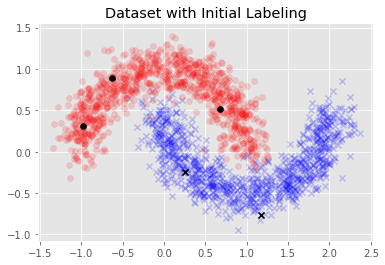

Num eigenvalues used = None
Compute eigs from scratch


In [288]:
# Underlying dataset- hyperparameters
N = 2000

X, labels = make_moons(N, noise=0.15)
gm = Graph_manager()



labels[np.where(labels == 0)[0]] = -1.

ind_ord = list(np.where(labels == -1)[0]) + list(np.where(labels == 1)[0])
ind_ordnp = np.array(ind_ord)


n_start = 5
labeled_orig = list(np.random.choice(list(range(N)), size=n_start, replace=False))
while sum(labels[labeled_orig]) == n_start or sum(labels[labeled_orig]) == 0:
    print('Rechoosing to get both clusters')
    labeled_orig = list(np.random.choice(list(range(N)), size=n_start, replace=False))

plot_iter(labels, X, labels, labeled_orig)



# Define the number of k-nearest neighbors
knn_ = 15

# Create similarity graph 
neig = None
graph_params = {
    'knn'    : knn_,
    'sigma'  : 3.,
    'Ltype'  : 'normed',
    'n_eigs' : neig,
    'zp_k'   : None
}

print('Num eigenvalues used = %s' %(str(neig))) 
w, v = gm.from_features(X, graph_params, debug=True)


# Define hyperparameter tau. WILL CHOOSE \gamma LATER, since Vopt and other criterion often 
# do better with different gamma
tau = 0.1

# Compute the prior covariance and related matrices
d = (tau ** (2.)) * ((w + tau**2.) ** (-1.))
Ct = v @ sp.sparse.diags(d, format='csr') @ v.T
Ct_inv = v @ sp.sparse.diags(1./d, format='csr') @ v.T  # spectral approximation
Lt = (tau ** (-2.)) * (gm.L + sp.sparse.diags(N*[tau**2.])).toarray() # "full" L_tau. 

In [289]:

GAMMAS = [0.01 + 0.01*j for j in range(4)] + [0.05+0.025*i for i in range(12)]
#GAMMAS = [0.01 + 0.01*j for j in range(6)]

print(GAMMAS)
max_errs = []
min_errs = []

for gamma in GAMMAS:
    print("gamma = %f" % gamma)
    # get the original data, before AL choices
    m = probit_map_dr2(labeled_orig, labels[labeled_orig], gamma, Ct)
    H = Hess2(m, labels[labeled_orig], labeled_orig, Ct_inv, gamma) 
    C = sp.linalg.inv(H) 
    labeled = copy.deepcopy(labeled_orig)
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    
    errs = []
    # See how bad Newton approximations are for this gamma
    for k in unlabeled:
        # get true MAP of plus k problem 
        labeledpk = labeled + [k]
        mk = probit_map_dr2(labeledpk, labels[labeledpk], gamma, Ct)
        
        # get Newton approx of MAP
        yk = labels[k]
        ck = C[k,:]
        ckk = ck[k]
        mkN = m + jac_calc2(m,yk, gamma)/(ckk*hess_calc2(m, yk, gamma) - 1.)*ck 
        errs.append(np.max(np.absolute(mk - mkN)))
        
        
    max_errs.append(np.max(errs))
    min_errs.append(np.min(errs))

[0.01, 0.02, 0.03, 0.04, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.175, 0.2, 0.22500000000000003, 0.25, 0.275, 0.3, 0.325]
gamma = 0.010000
gamma = 0.020000
gamma = 0.030000
gamma = 0.040000
gamma = 0.050000
gamma = 0.075000
gamma = 0.100000
gamma = 0.125000
gamma = 0.150000
gamma = 0.175000
gamma = 0.200000
gamma = 0.225000
gamma = 0.250000
gamma = 0.275000
gamma = 0.300000
gamma = 0.325000


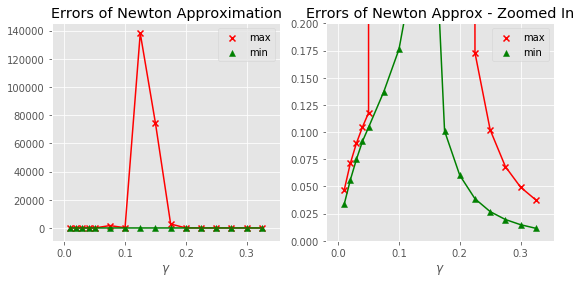

In [290]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.scatter(GAMMAS, max_errs, c='r', marker='x', label='max')
plt.plot(GAMMAS, max_errs, 'r')
plt.scatter(GAMMAS, min_errs, c='g', marker='^', label='min')
plt.plot(GAMMAS, min_errs, 'g')
plt.legend()
plt.title('Errors of Newton Approximation')
plt.xlabel(r'$\gamma$')

plt.subplot(1,2,2)
plt.scatter(GAMMAS, max_errs, c='r', marker='x', label='max')
plt.plot(GAMMAS, max_errs, 'r')
plt.scatter(GAMMAS, min_errs, c='g', marker='^', label='min')
plt.plot(GAMMAS, min_errs, 'g')
plt.ylim(0,.2)
plt.legend()
plt.title('Errors of Newton Approx - Zoomed In')
plt.xlabel(r'$\gamma$')
plt.show()

In [334]:
exact = False

In [335]:
VCHOICES = []
V_ACC = []


for gamma in GAMMAS:
    print("gamma = %f" % gamma)
    # get the original data, before AL choices
    m = probit_map_dr2(labeled_orig, labels[labeled_orig], gamma, Ct)
    H = Hess2(m, labels[labeled_orig], labeled_orig, Ct_inv, gamma) 
    C = sp.linalg.inv(H) 
    labeled = copy.deepcopy(labeled_orig)
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    
    # Run Vopt choices
    v_choices = []
    v_acc = []
    v_acc.append(get_acc(m, labels)[1])



    for i in range(num_to_query):
        # Calculate V-Opt criterion for unlabeled points
        unlabeled = list(filter(lambda x: x not in labeled, range(N)))
        k, vopt = V_opt_record(C, unlabeled, gamma**2)

        # update labeled
        labeled += [k]
        v_choices.append(k)

        if exact:
            # Exact Covariance calculation
            m = probit_map_dr2(labeled, labels[labeled], gamma, Ct)
            H = Hess2(m, labels[labeled], labeled, Ct_inv, gamma) 
            C = sp.linalg.inv(H)
        else:
            # Newton Approx with Hessian approx
            yk = labels[k]
            ck = C[k,:]
            ckk = ck[k]
            m += jac_calc2(m,yk, gamma)/(ckk*hess_calc2(m, yk, gamma) - 1.)*ck  # Newton update for m


            # Update inverse Hessian (approximate old Hessian at new MAP estimator by old Hessian at old MAP estimator)
            #   Numerics seem to support could be okay
            C -= (hess_calc2(m, yk, gamma)/ (ckk*hess_calc2(m, yk, gamma)  - 1.) )* np.outer(ck, ck)
        v_acc.append(get_acc(m, labels)[1])
    VCHOICES.append(v_choices)
    V_ACC.append(v_acc)
    
    
VCHOICES = np.array(VCHOICES)
V_ACC = np.array(V_ACC)

gamma = 0.010000
gamma = 0.020000
gamma = 0.030000
gamma = 0.040000
gamma = 0.050000
gamma = 0.075000
gamma = 0.100000
gamma = 0.125000
gamma = 0.150000
gamma = 0.175000


/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in true_divide
  
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


gamma = 0.200000
gamma = 0.225000
gamma = 0.250000
gamma = 0.275000
gamma = 0.300000
gamma = 0.325000


In [336]:
M_ACC = []
MCHOICES = []

for gamma in GAMMAS:
    print("gamma = %f" % gamma)
    # get the original data, before AL choices
    m = probit_map_dr2(labeled_orig, labels[labeled_orig], gamma, Ct)
    H = Hess2(m, labels[labeled_orig], labeled_orig, Ct_inv, gamma) 
    C = sp.linalg.inv(H) 
    labeled = copy.deepcopy(labeled_orig)
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    
    # Run Model Change choices
    m_choices = []
    m_acc = []
    m_acc.append(get_acc(m, labels)[1])

    for i in range(num_to_query):
        # Calculate V-Opt criterion for unlabeled points
        unlabeled = list(filter(lambda x: x not in labeled, range(N)))
        k, mopt = model_change_crit_record(m, C, unlabeled, gamma)

        # update labeled
        labeled += [k]
        m_choices.append(k)

        if exact:
            # Exact Covariance calculation
            m = probit_map_dr2(labeled, labels[labeled], gamma, Ct)
            H = Hess2(m, labels[labeled], labeled, Ct_inv, gamma) 
            C = sp.linalg.inv(H)
        else:
            # Newton Approx with Hessian approx
            yk = labels[k]
            ck = C[k,:]
            ckk = ck[k]
            m += jac_calc2(m,yk, gamma)/(ckk*hess_calc2(m, yk, gamma) - 1.)*ck  # Newton update for m


            # Update inverse Hessian (approximate old Hessian at new MAP estimator by old Hessian at old MAP estimator)
            #   Numerics seem to support could be okay
            C -= (hess_calc2(m, yk, gamma)/ (ckk*hess_calc2(m, yk, gamma)  - 1.) )* np.outer(ck, ck)
        
        m_acc.append(get_acc(m, labels)[1])
    
    MCHOICES.append(m_choices)
    M_ACC.append(m_acc)
    
    
MCHOICES = np.array(MCHOICES)
M_ACC = np.array(M_ACC)

gamma = 0.010000
gamma = 0.020000
gamma = 0.030000
gamma = 0.040000
gamma = 0.050000
gamma = 0.075000
gamma = 0.100000
gamma = 0.125000


/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


gamma = 0.150000
gamma = 0.175000


/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


gamma = 0.200000
gamma = 0.225000
gamma = 0.250000
gamma = 0.275000
gamma = 0.300000
gamma = 0.325000


In [ ]:
D_ACC = []
DCHOICES = []

for gamma in GAMMAS:
    print("gamma = %f" % gamma)
    # get the original data, before AL choices
    m = probit_map_dr2(labeled_orig, labels[labeled_orig], gamma, Ct)
    H = Hess2(m, labels[labeled_orig], labeled_orig, Ct_inv, gamma) 
    C = sp.linalg.inv(H) 
    labeled = copy.deepcopy(labeled_orig)
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    
    # Run Model Change choices
    d_choices = []
    d_acc = []
    d_acc.append(get_acc(m, labels)[1])

    for i in range(num_to_query):
        # Calculate V-Opt criterion for unlabeled points
        unlabeled = list(filter(lambda x: x not in labeled, range(N)))
        k, dopt = db_crit(m, unlabeled)

        # update labeled
        labeled += [k]
        d_choices.append(k)

        if exact:
            # Exact Covariance calculation
            m = probit_map_dr2(labeled, labels[labeled], gamma, Ct)
            H = Hess2(m, labels[labeled], labeled, Ct_inv, gamma) 
            C = sp.linalg.inv(H)
        else:
            # Newton Approx with Hessian approx
            yk = labels[k]
            ck = C[k,:]
            ckk = ck[k]
            m += jac_calc2(m,yk, gamma)/(ckk*hess_calc2(m, yk, gamma) - 1.)*ck  # Newton update for m


            # Update inverse Hessian (approximate old Hessian at new MAP estimator by old Hessian at old MAP estimator)
            #   Numerics seem to support could be okay
            C -= (hess_calc2(m, yk, gamma)/ (ckk*hess_calc2(m, yk, gamma)  - 1.) )* np.outer(ck, ck)
        
        d_acc.append(get_acc(m, labels)[1])
    
    DCHOICES.append(d_choices)
    D_ACC.append(d_acc)
    
    
DCHOICES = np.array(DCHOICES)
D_ACC = np.array(D_ACC)

In [344]:
if exact:
    np.save('exact.npy', dict({'GAMMAS':GAMMAS, 'VCHOICES':VCHOICES, 'MCHOICES':MCHOICES,
                     'V_ACC':V_ACC, 'M_ACC':M_ACC, 'DCHOICES':DCHOICES, 'D_ACC':D_ACC, 'X':X, 'labeled':labeled_orig}))
else:
    np.save('NewtonApprox.npy', dict({'GAMMAS':GAMMAS, 'VCHOICES':VCHOICES, 'MCHOICES':MCHOICES,
                     'V_ACC':V_ACC, 'M_ACC':M_ACC, 'DCHOICES':DCHOICES, 'D_ACC':D_ACC, 'X':X, 'labeled':labeled_orig}))

In [345]:
def plot_choices(choices, gammas, X, labeled, al_type='Vopt', exact=True, save=False):
    N = X.shape[0]
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))

    plt.figure(figsize=(12,24))
    for i, gamma in enumerate(gammas):
        plt.subplot(6,3,i+1)
        plt.scatter(X[unlabeled, 0], X[unlabeled, 1], marker='o')
        plt.scatter(X[labeled, 0], X[labeled, 1], marker='^', c='k', s=70, label='labeled')
        plt.scatter(X[choices[i,:],0], X[choices[i,:], 1], marker='s', c='b',s=90, label='%s choices' % al_type)
        plt.legend()
        plt.title(r'$\gamma=$ %1.3f' % gamma)

    if exact:
        plt.suptitle('%s Choices - Exact MAP + Hessian' % al_type)
        exact_s = 'exact'
    else:
        plt.suptitle('%s Choices - Newton Approx' % al_type)
        exact_s = 'NA'
    
    if save:
        plt.savefig('%s_Choices_%s.png' %(al_type, exact_s))
    plt.show()
    return
   
markers = ['x', '+', '^', '<', '>', 'v', '8','s','p']
markers = markers + markers
def plot_acc(acc, gammas, al_type='Vopt', exact=True, save=False):
    # Accuracy plots for Model Choice
    plt.figure(figsize=(12,6))
    for i, gamma in enumerate(GAMMAS):
        plt.subplot(1,2,(i//9)+1)
        plt.scatter(range(acc.shape[1]), acc[i,:], marker= markers[i], label=r'$\gamma=$ %1.3f' % gamma)
        plt.plot(range(acc.shape[1]), acc[i,:])
        plt.ylim(0.5,1.0)
        plt.legend()
        plt.xlabel('# of AL choices')
    if exact:
        plt.suptitle('%s Acc - Exact MAP + Hessian' % al_type)
        exact_s = 'exact'
    else:
        plt.suptitle('%s Acc - Newton Approx' % al_type)
        exact_s = 'NA'

    if save:
        plt.savefig('%s_acc_%s.png' % (al_type, exact_s))
    plt.show()

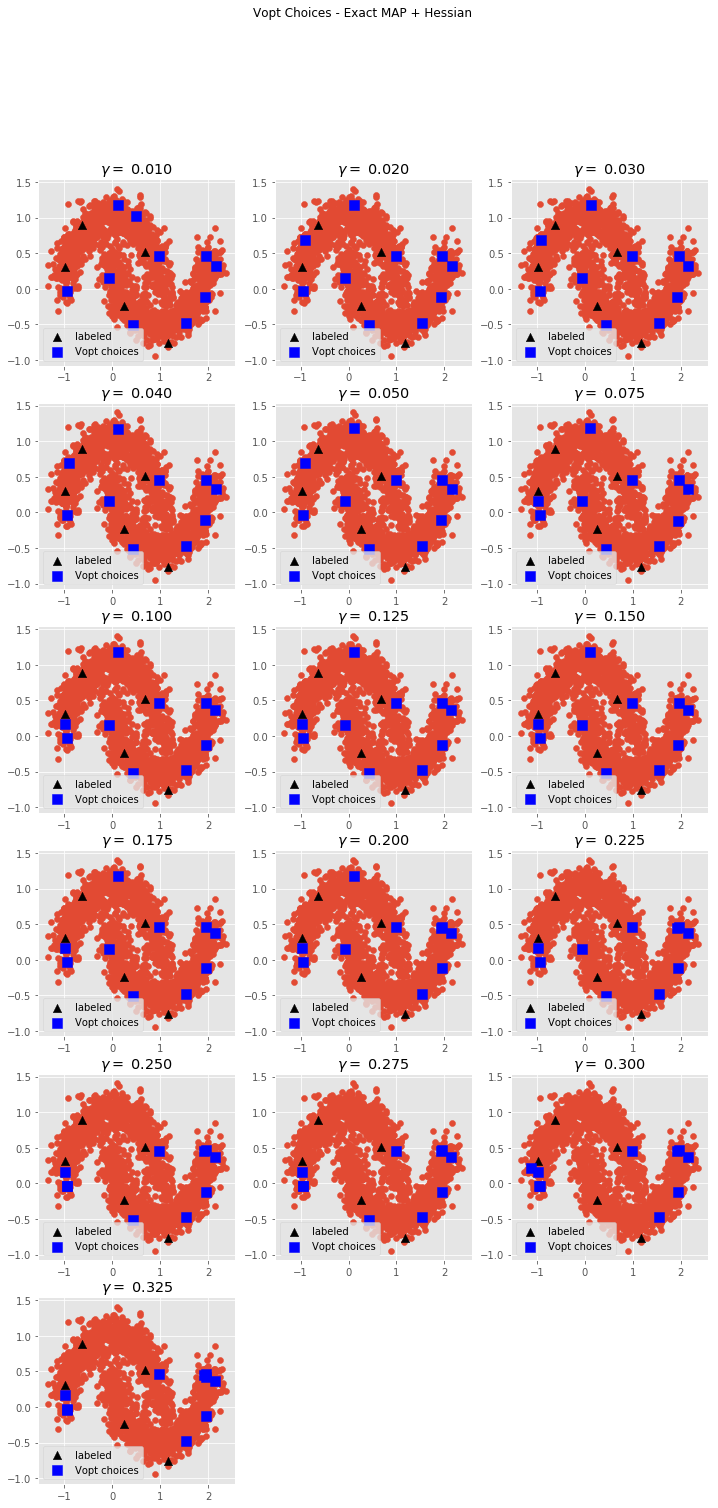

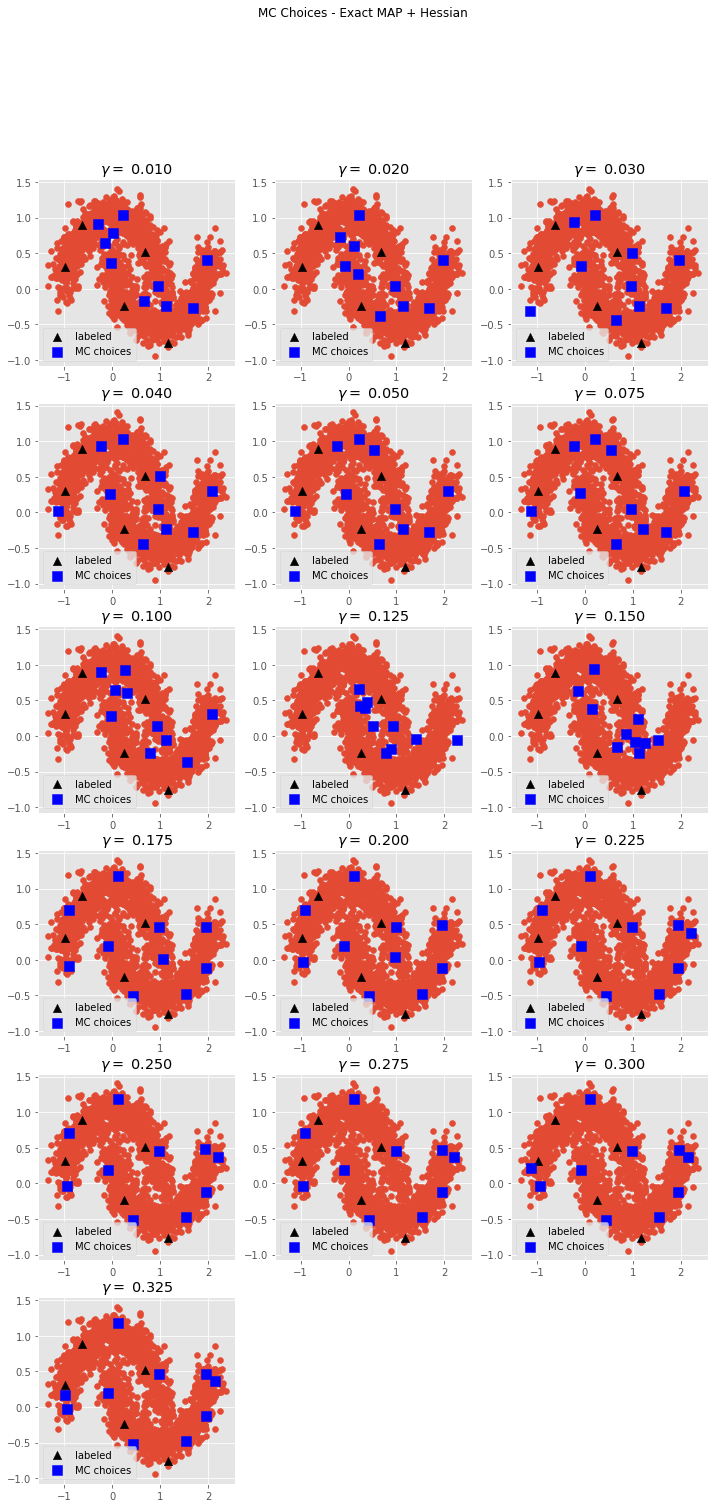

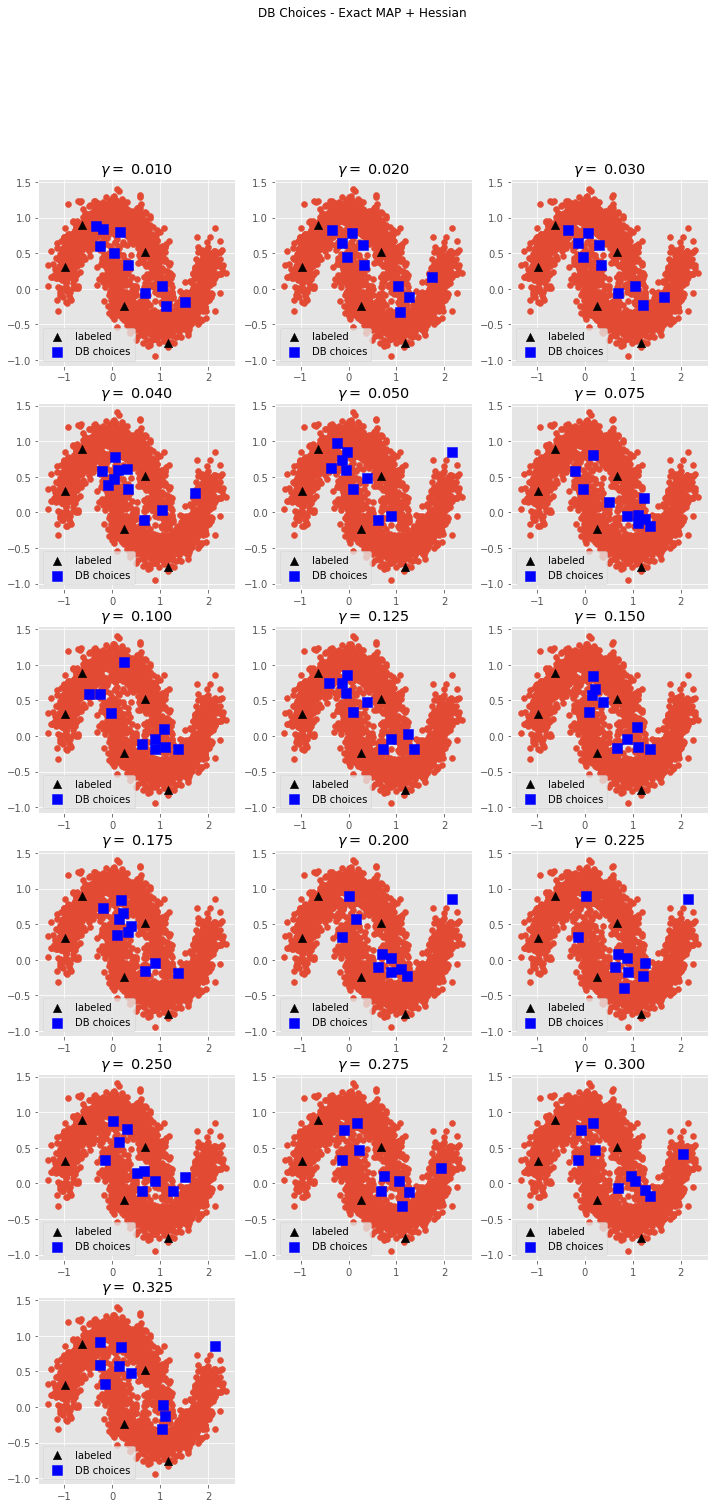

/Users/Kevin/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


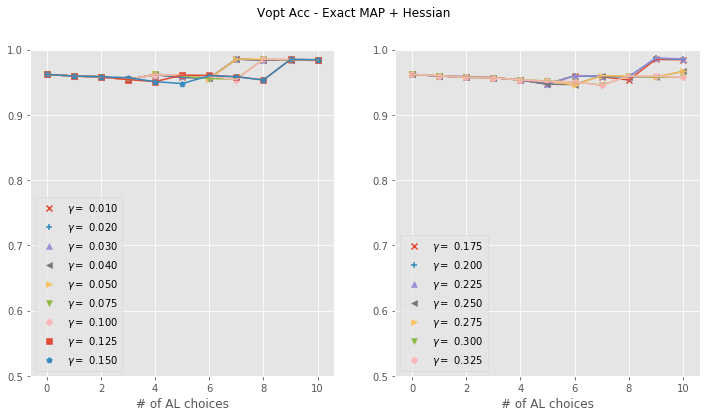

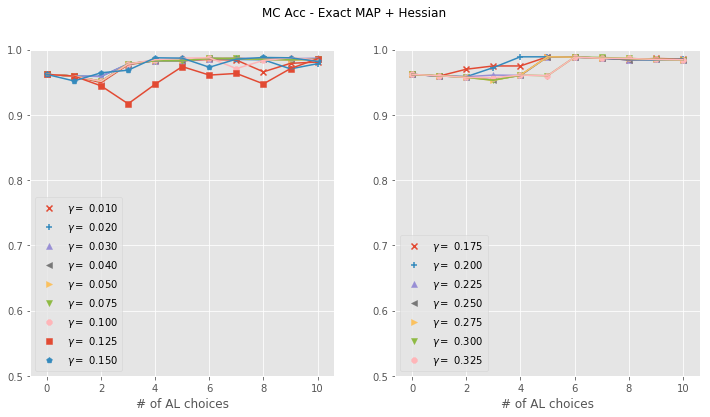

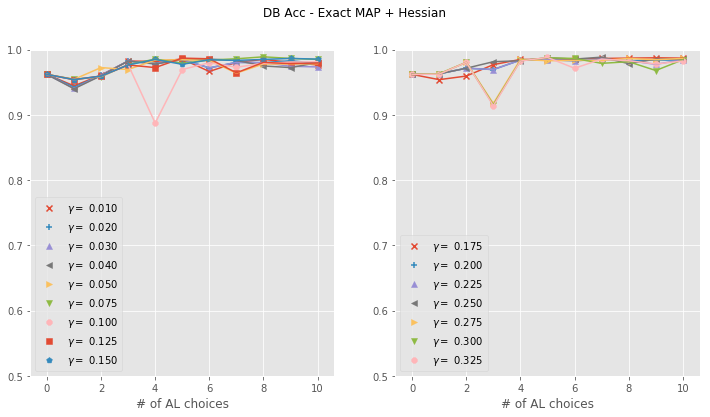

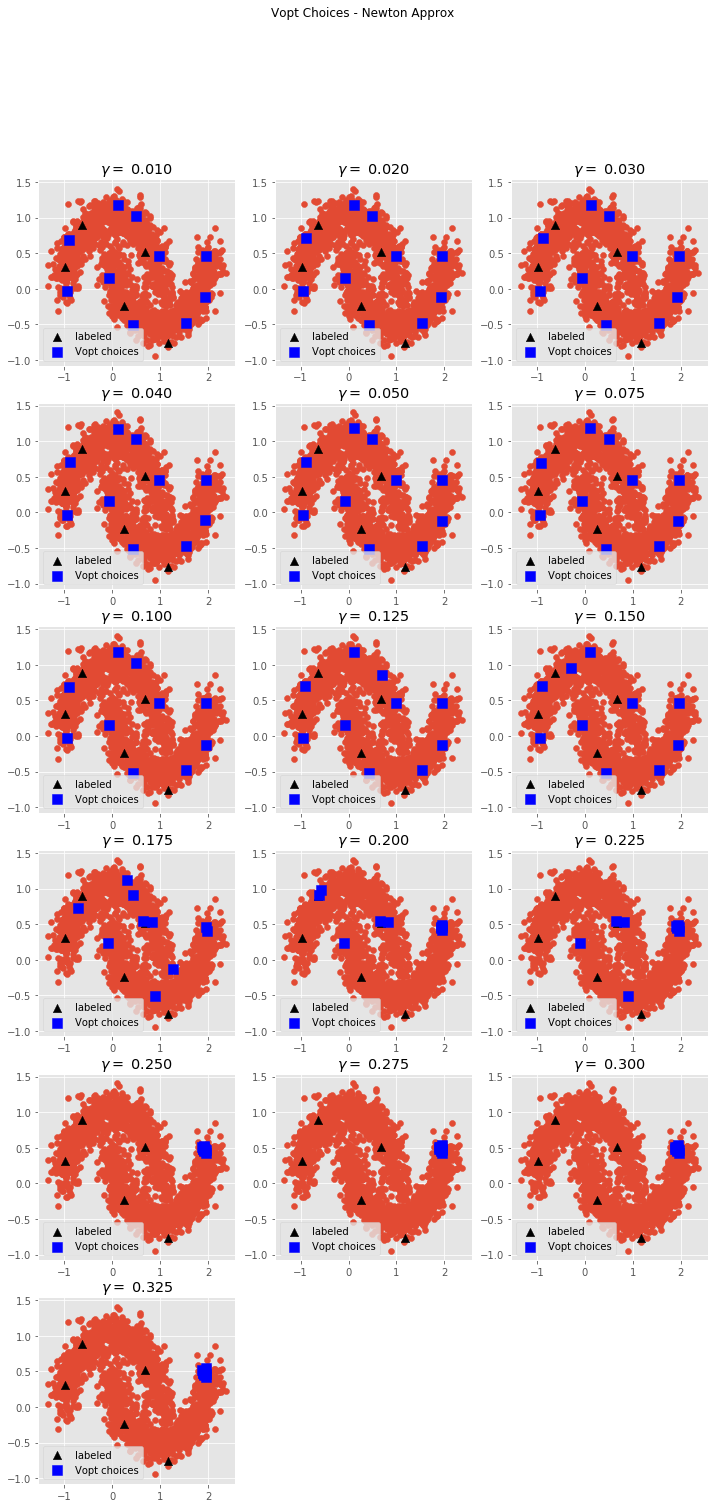

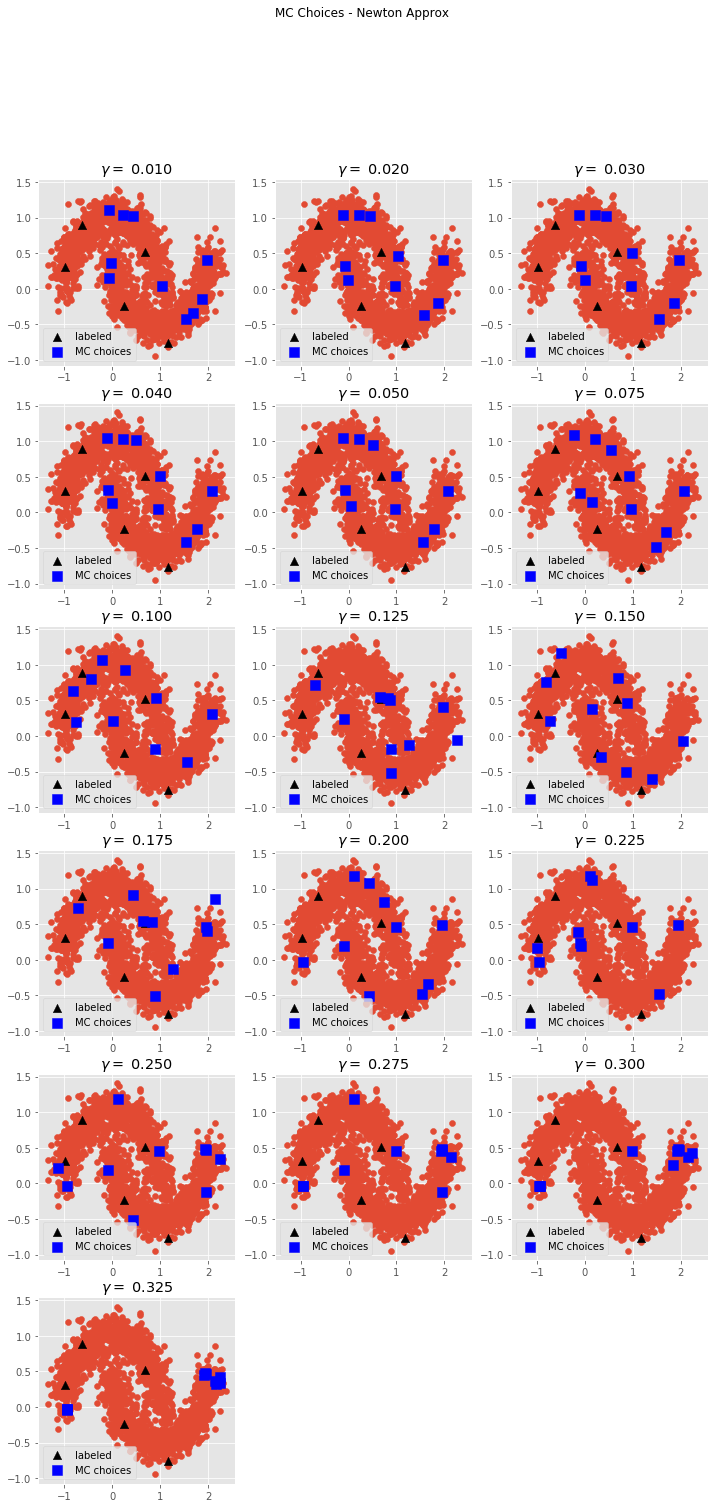

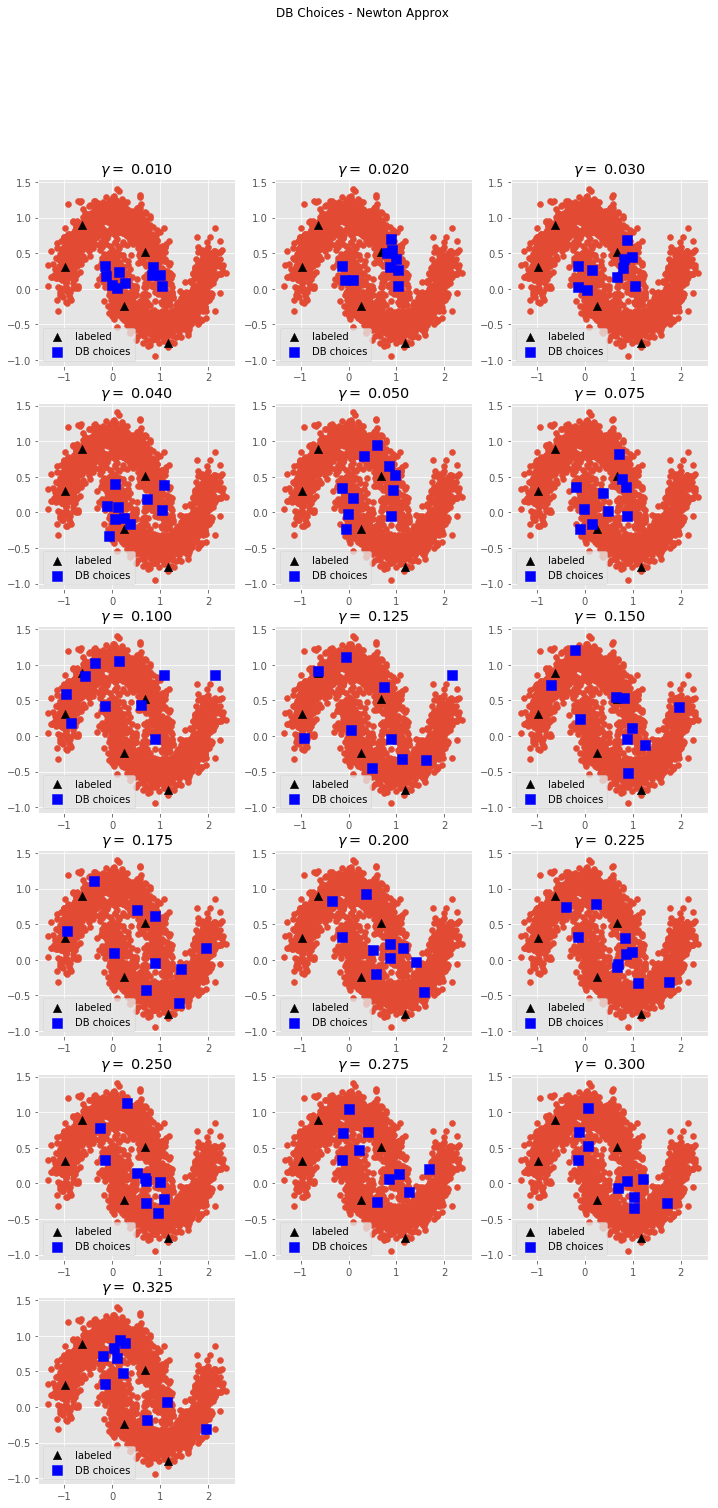

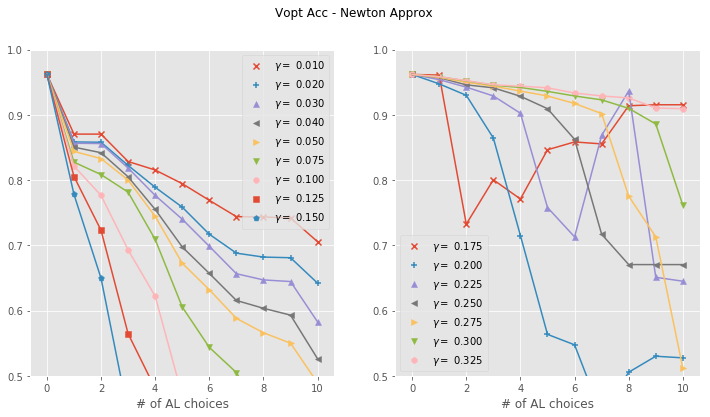

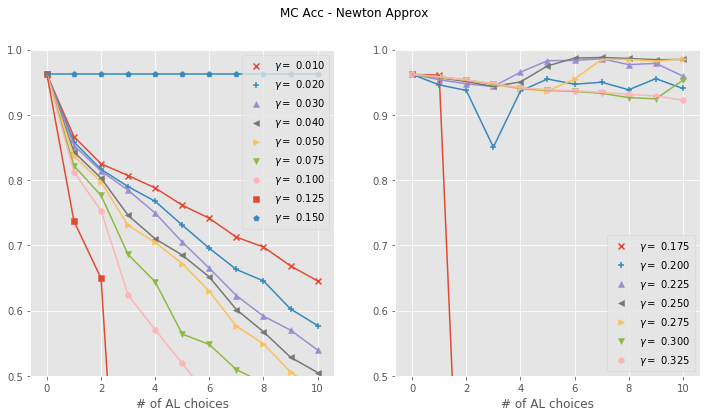

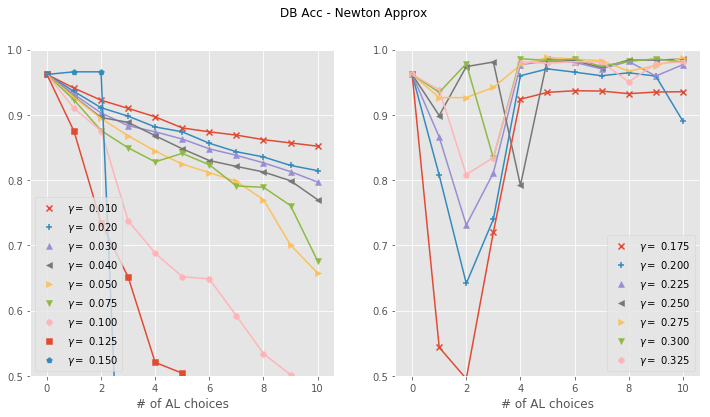

In [352]:
for exact in [True, False]:
    if exact:
        data = np.load('exact.npy')
        
    else:
        data = np.load('NewtonApprox.npy')
        
    GAMMAS = data[()]['GAMMAS']
    VCHOICES = data[()]['VCHOICES']
    MCHOICES = data[()]['MCHOICES']
    DCHOICES = data[()]['DCHOICES']
    M_ACC = data[()]['M_ACC']
    V_ACC = data[()]['V_ACC']
    D_ACC = data[()]['D_ACC']
    X = data[()]['X']
    labeled = data[()]['labeled']
    
    plot_choices(VCHOICES, GAMMAS, X, labeled, al_type='Vopt',exact=exact, save=True)
    plot_choices(MCHOICES, GAMMAS, X, labeled, al_type='MC',exact=exact, save=True)
    plot_choices(DCHOICES, GAMMAS, X, labeled, al_type='DB',exact=exact, save=True)
    plot_acc(V_ACC, GAMMAS, al_type='Vopt',exact=exact, save=True)
    plot_acc(M_ACC, GAMMAS, al_type='MC',exact=exact, save=True)
    plot_acc(D_ACC, GAMMAS, al_type='DB',exact=exact, save=True)